# $7^{th}$ exercise

## Notebook setup

#### Used libraries

In [117]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


#### Functions

In [148]:
def Ac(data,dt):
    d0=data[:-dt]
    d1=data[dt:]
    num = np.average(d0*d1) - np.average(d0) * np.average(d1)
    return num/np.var(data)

def Err(ave, av2, n):
    if n == 0:
        return 0
    return np.sqrt((av2 - ave**2) / n)

def DataBlockingErr(data,n_blocks,steps):
    ave=0.
    av2=0.
    for n in range(n_blocks):
        blkave=np.sum(data[n*steps:(n+1)*steps])/steps
        ave+=blkave
        av2+=blkave**2
    return Err(ave/n_blocks, av2/n_blocks,n_blocks-1)


#### Useful variables

In [30]:
states = ("solid","liquid","gas")

#### Colors, just for fun

In [3]:
stb = "#191724" #background
ndb = "#26233a" #object background
ste = "#e0def4" #main elements
nde = "#f6c177" #additional elements
rde = "#eb6f92" #element in evidence
err = "#908caa" #error bar
er2 = "#6e6a86" #second error bar

## 04.2 - Molecular dynamics in the microcanonical ensamble: Argon in the Lennard-Jones approximation

### Introductory notes


### Brief recap
**Goal:** Simulate a system of Argon in the Lennard-Jones approximation in the phases:
- Solid $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- Liquid $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- Gas $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

**Expectations:**  

### Equilibration

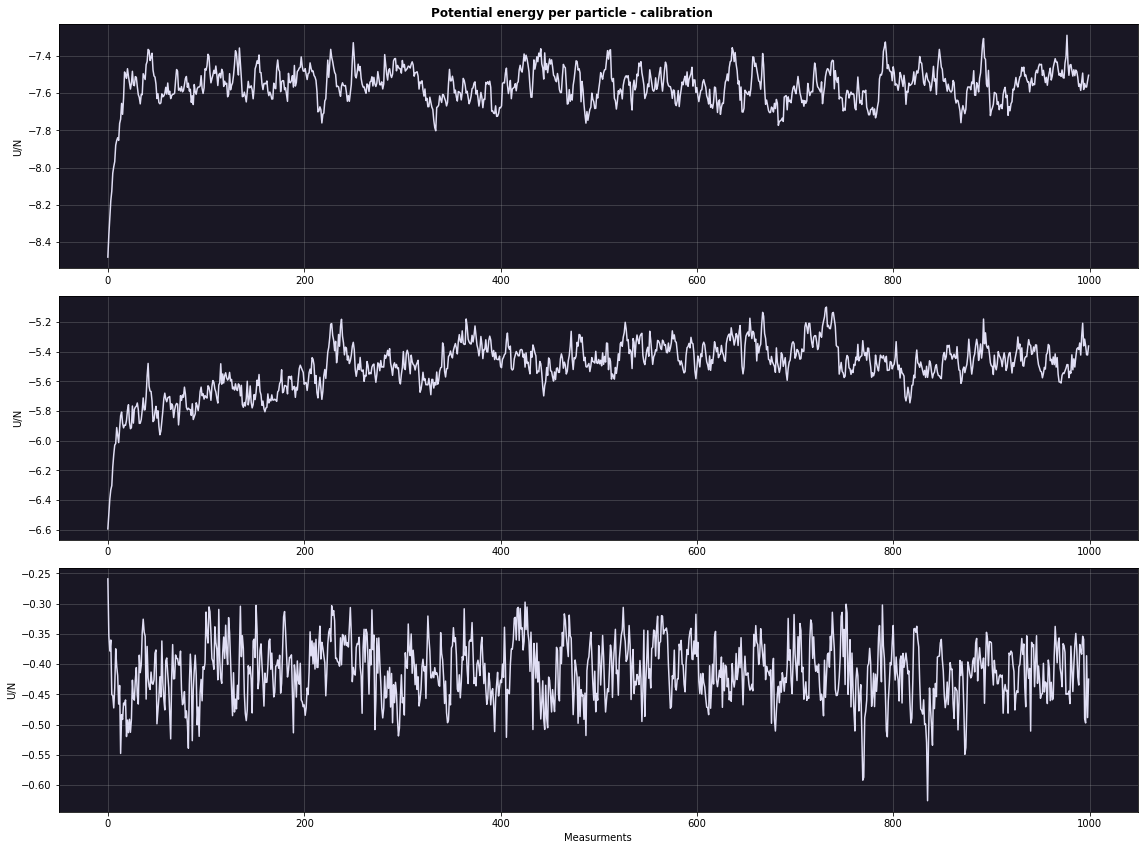

In [159]:
fig=plt.figure(figsize=(16, 12))
x=np.arange(0,1000)

plt.suptitle('Potential energy per particle - calibration', weight='bold')

for i in (0,1,2):
    y = np.loadtxt("store/"+states[i]+"/equi.dat", usecols=0,unpack=True)

    plt.subplot(3,1,i+1)
    fig.axes[i].set_facecolor(stb)

    plt.plot(x,y,color=ste)

    plt.ylabel('U/N')
    plt.grid(alpha=0.3)


plt.xlabel('Measurments')

plt.tight_layout()
plt.show()

After about 500 steps the potential energy stabilizes for the solid and liquid state, while it takes 1500 steps in the gas state to stabilize. 

### Autocorrelation

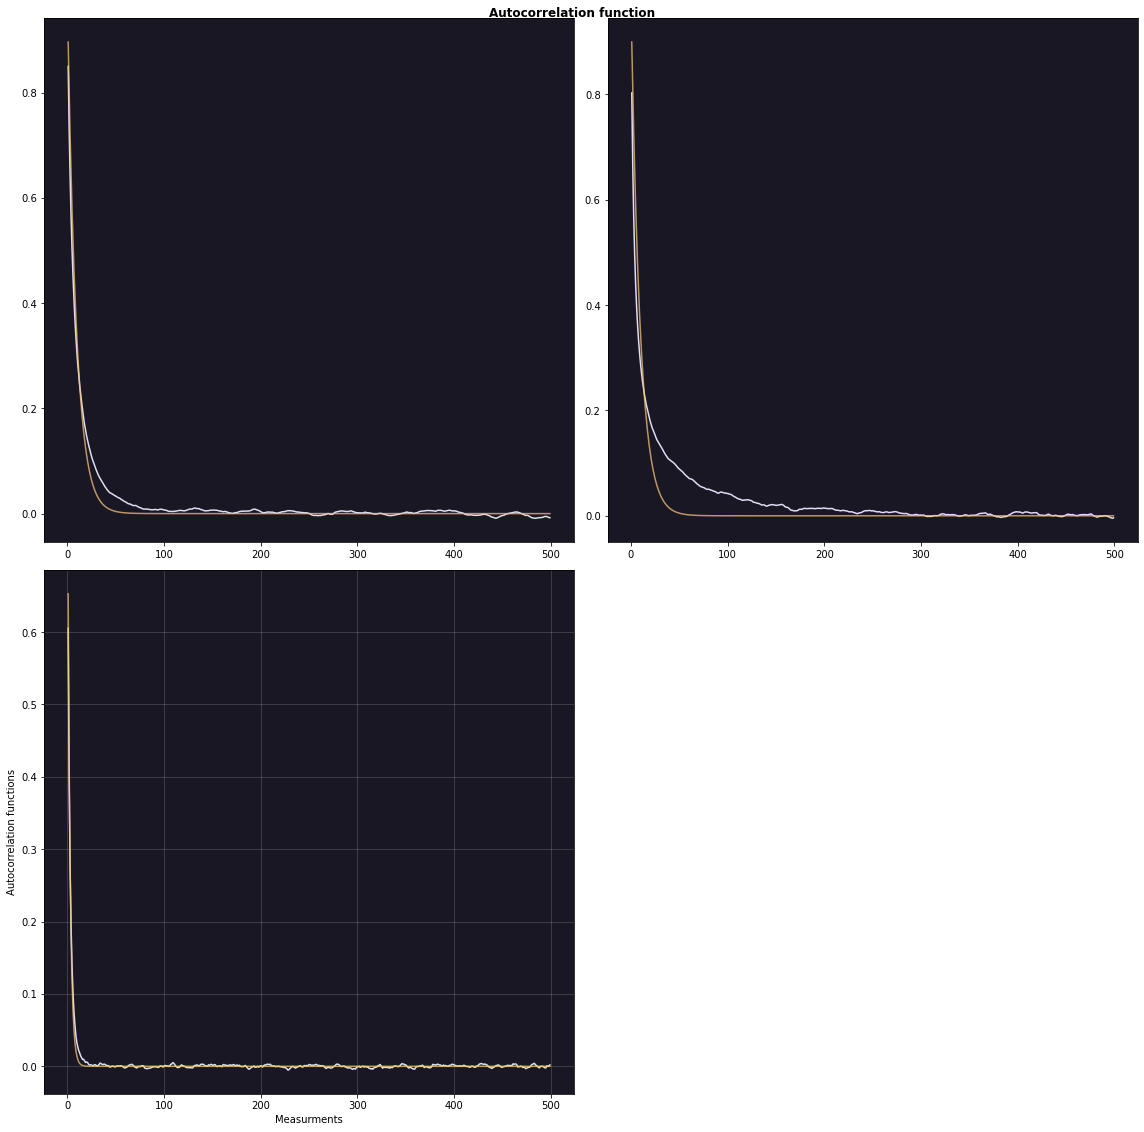

In [160]:
def f(x, t_c):
    return  np.exp(-x/t_c)

fig=plt.figure(figsize=(16, 16))
x=np.arange(1,500)

plt.suptitle('Autocorrelation function', weight='bold')

for i in (0,1,2):
    plt.subplot(2,2,i+1)
    fig.axes[i].set_facecolor(stb)

    data = np.loadtxt("store/"+states[i]+"/epot_instant.dat", usecols=0,unpack=True)
    y=np.fromiter((Ac(data,i) for i in x),np.double)
    plt.plot(x,y,color=ste)
    
    popt, pcov = curve_fit(f, x, y)
    plt.plot(x, f(x, *popt), label="Fit", color=nde, alpha=0.75)

plt.ylabel('Autocorrelation functions')
plt.xlabel('Measurments')

plt.grid(alpha=0.3)



plt.tight_layout()
plt.show()

### Liquid
#### Equilibration

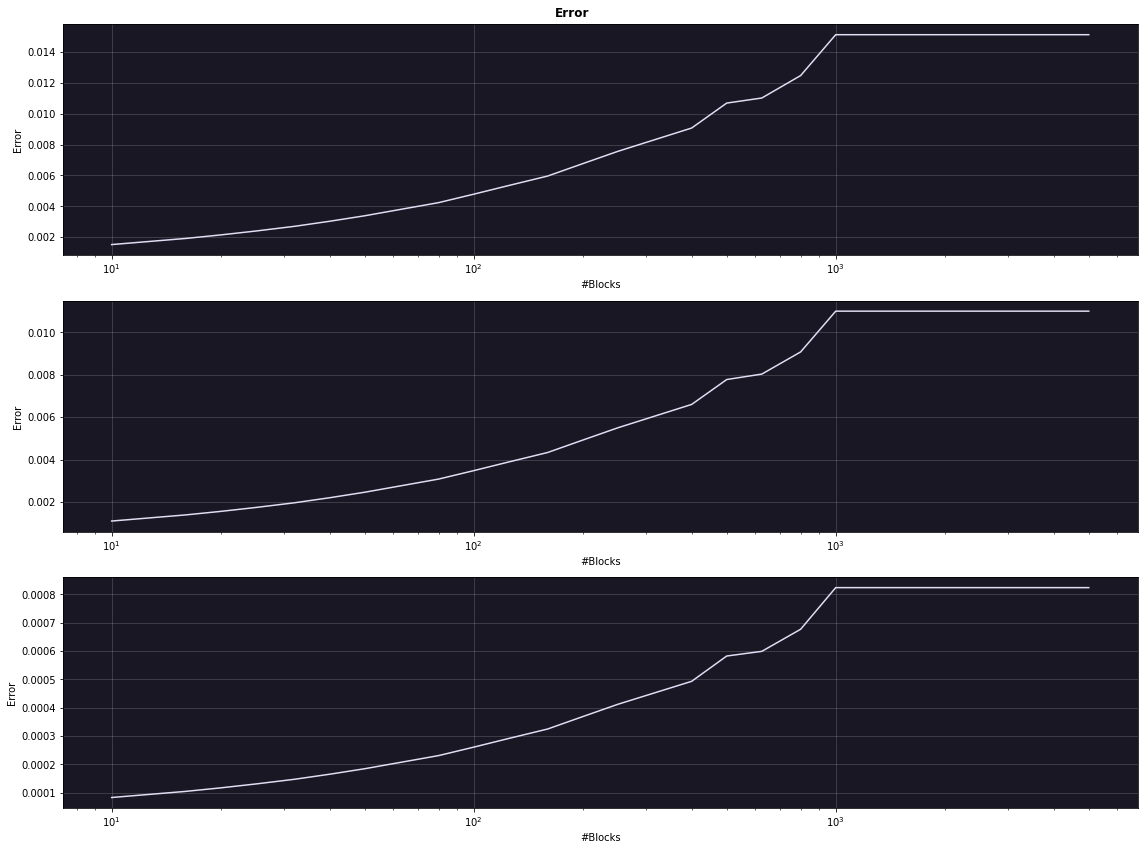

In [168]:
fig=plt.figure(figsize=(16, 12))
stepss=np.array([10,16,20,25,32,40,50,80,100,125,160,200,250,400,500,625,800,1000,1250,2000,2500,3125,4000,5000])

x=np.arange(len(stepss))

plt.suptitle('Error', weight='bold')

for i in (0,1,2):
    plt.subplot(3,1,i+1)
    fig.axes[i].set_facecolor(stb)
    data = np.loadtxt("store/"+states[i]+"_epot_instant.dat", usecols=0,unpack=True, max_rows=nout)
    y=np.fromiter((DataBlockingErr(data,int(500000/steps),steps) for steps in stepss),np.double)

    plt.plot(stepss,y,color=ste)
    
    plt.xscale("log")

    plt.ylabel('Error')
    plt.xlabel('#Blocks')

    plt.grid(alpha=0.3)



plt.tight_layout()
plt.show()

As we can see, after 200 blocks it almost saturate the error. All considered, we choose 500 as block size.

#### Simulation

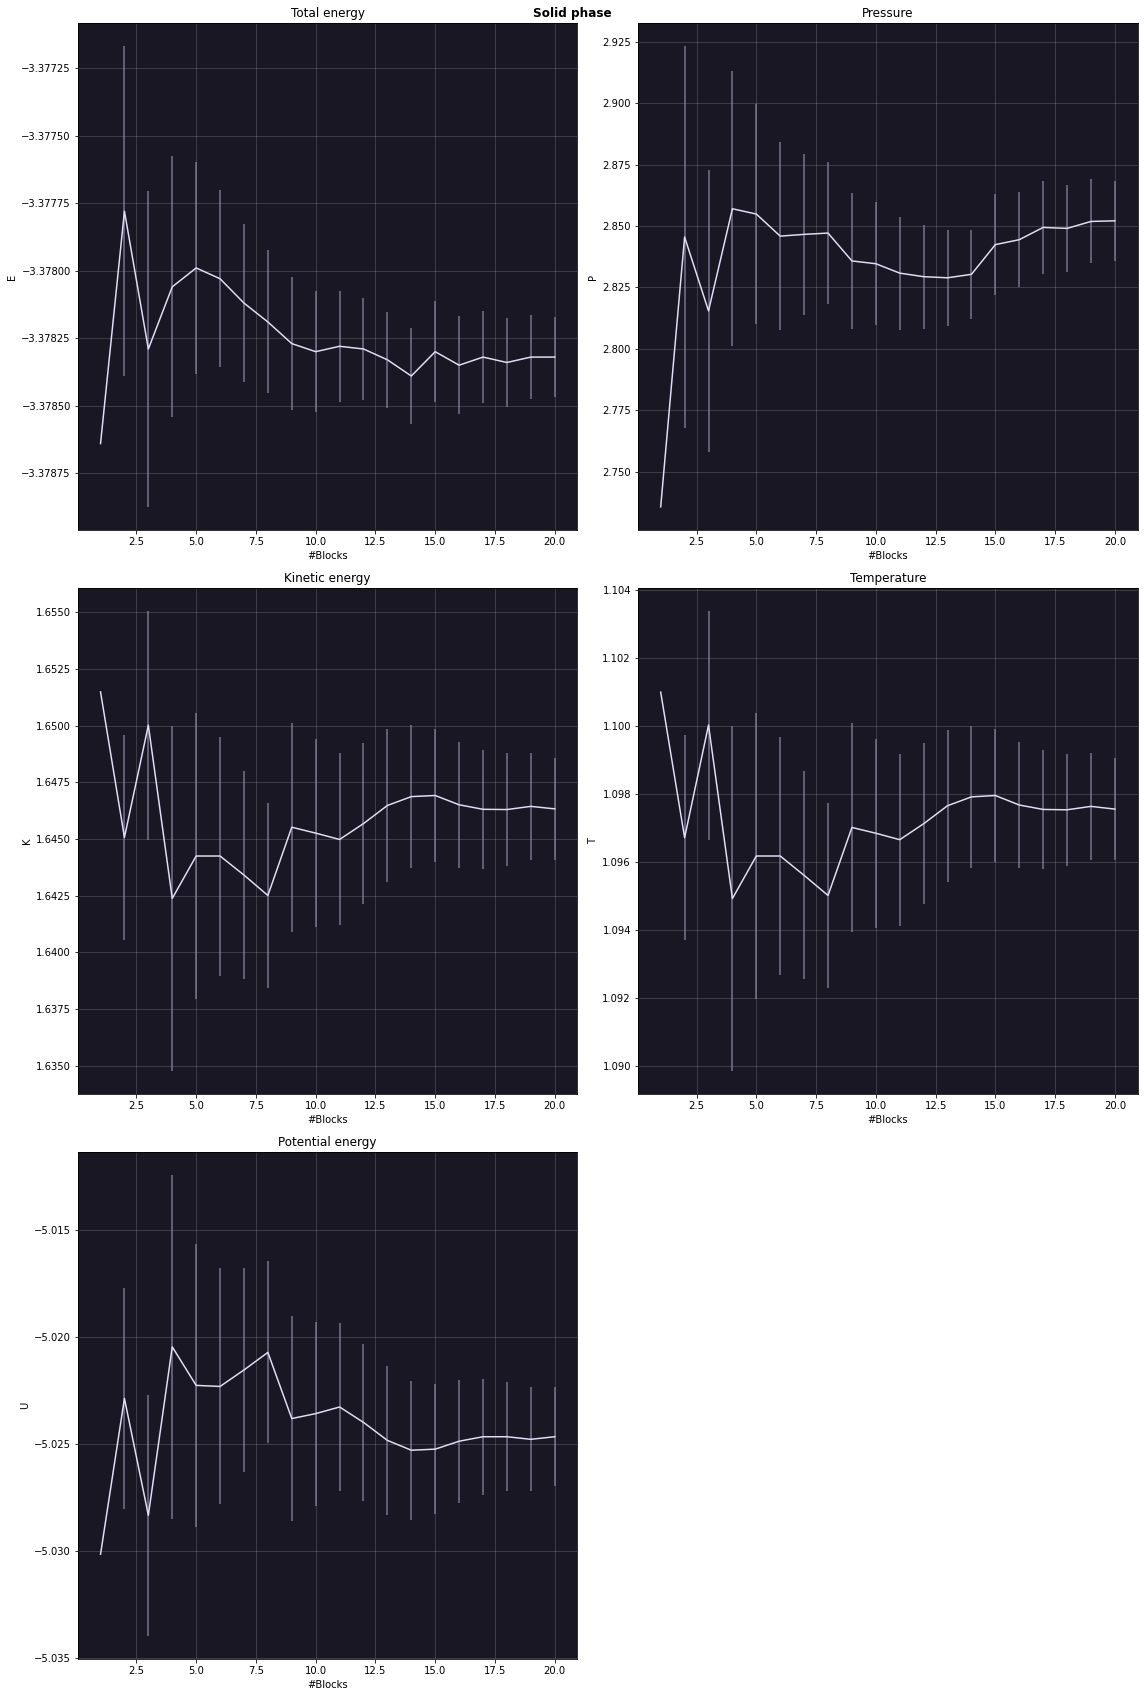

In [23]:
state="liquid"

fig=plt.figure(figsize=(16, 24))
plt.suptitle('Solid phase', weight='bold')

#Total energy
x,y,e = np.loadtxt("out/"+state+"/output_etot.dat", usecols=(0,2,3),unpack=True)

plt.subplot(321)
fig.axes[0].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('E')
plt.title("Total energy")
plt.grid(alpha=0.3)

#Kinetic energy
x,y,e = np.loadtxt("out/"+state+"/output_ekin.dat", usecols=(0,2,3),unpack=True)

plt.subplot(323)
fig.axes[1].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('K')
plt.title("Kinetic energy")
plt.grid(alpha=0.3)

#Potential energy
x,y,e = np.loadtxt("out/"+state+"/output_epot.dat", usecols=(0,2,3),unpack=True)

plt.subplot(325)
fig.axes[2].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('U')
plt.title("Potential energy")
plt.grid(alpha=0.3)

#Pressure energy
x,y,e = np.loadtxt("out/"+state+"/output_pres.dat", usecols=(0,2,3),unpack=True)

plt.subplot(322)
fig.axes[3].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('P')
plt.title("Pressure")
plt.grid(alpha=0.3)

#Temperature energy
x,y,e = np.loadtxt("out/"+state+"/output_temp.dat", usecols=(0,2,3),unpack=True)

plt.subplot(324)
fig.axes[4].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('T')
plt.title("Temperature")
plt.grid(alpha=0.3)


plt.tight_layout()


plt.show()

### Gas
#### Equilibration

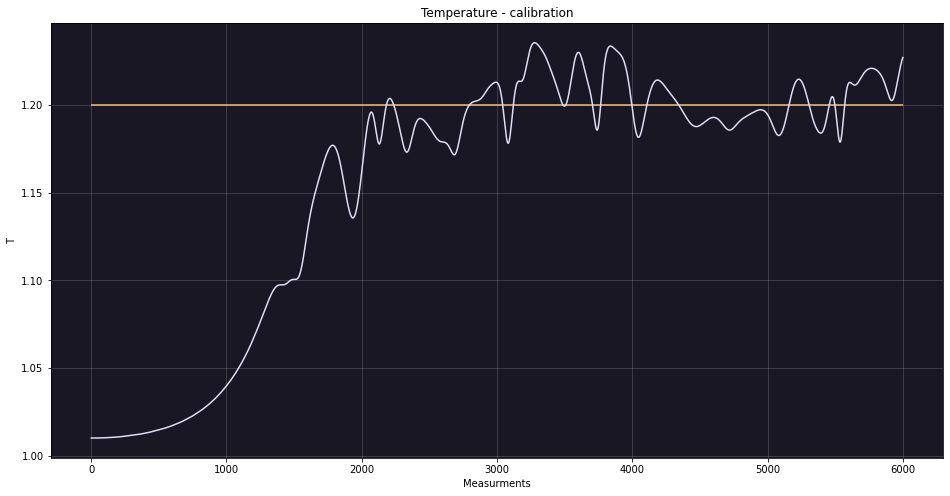

In [20]:
fig=plt.figure(figsize=(16, 8))

state="gas"
x,y = np.loadtxt("store/"+state+"_equilibration.dat", usecols=(0,1),unpack=True)

plt.axes().set_facecolor(stb)

plt.hlines(1.2, 0,6000,color=nde)
plt.errorbar(x,y,color=ste)

plt.xlabel('Measurments')
plt.ylabel('T')
plt.title("Temperature - calibration")
plt.grid(alpha=0.3)

plt.show()

In this case the equilibration is much longer, since .......

#### Simulation

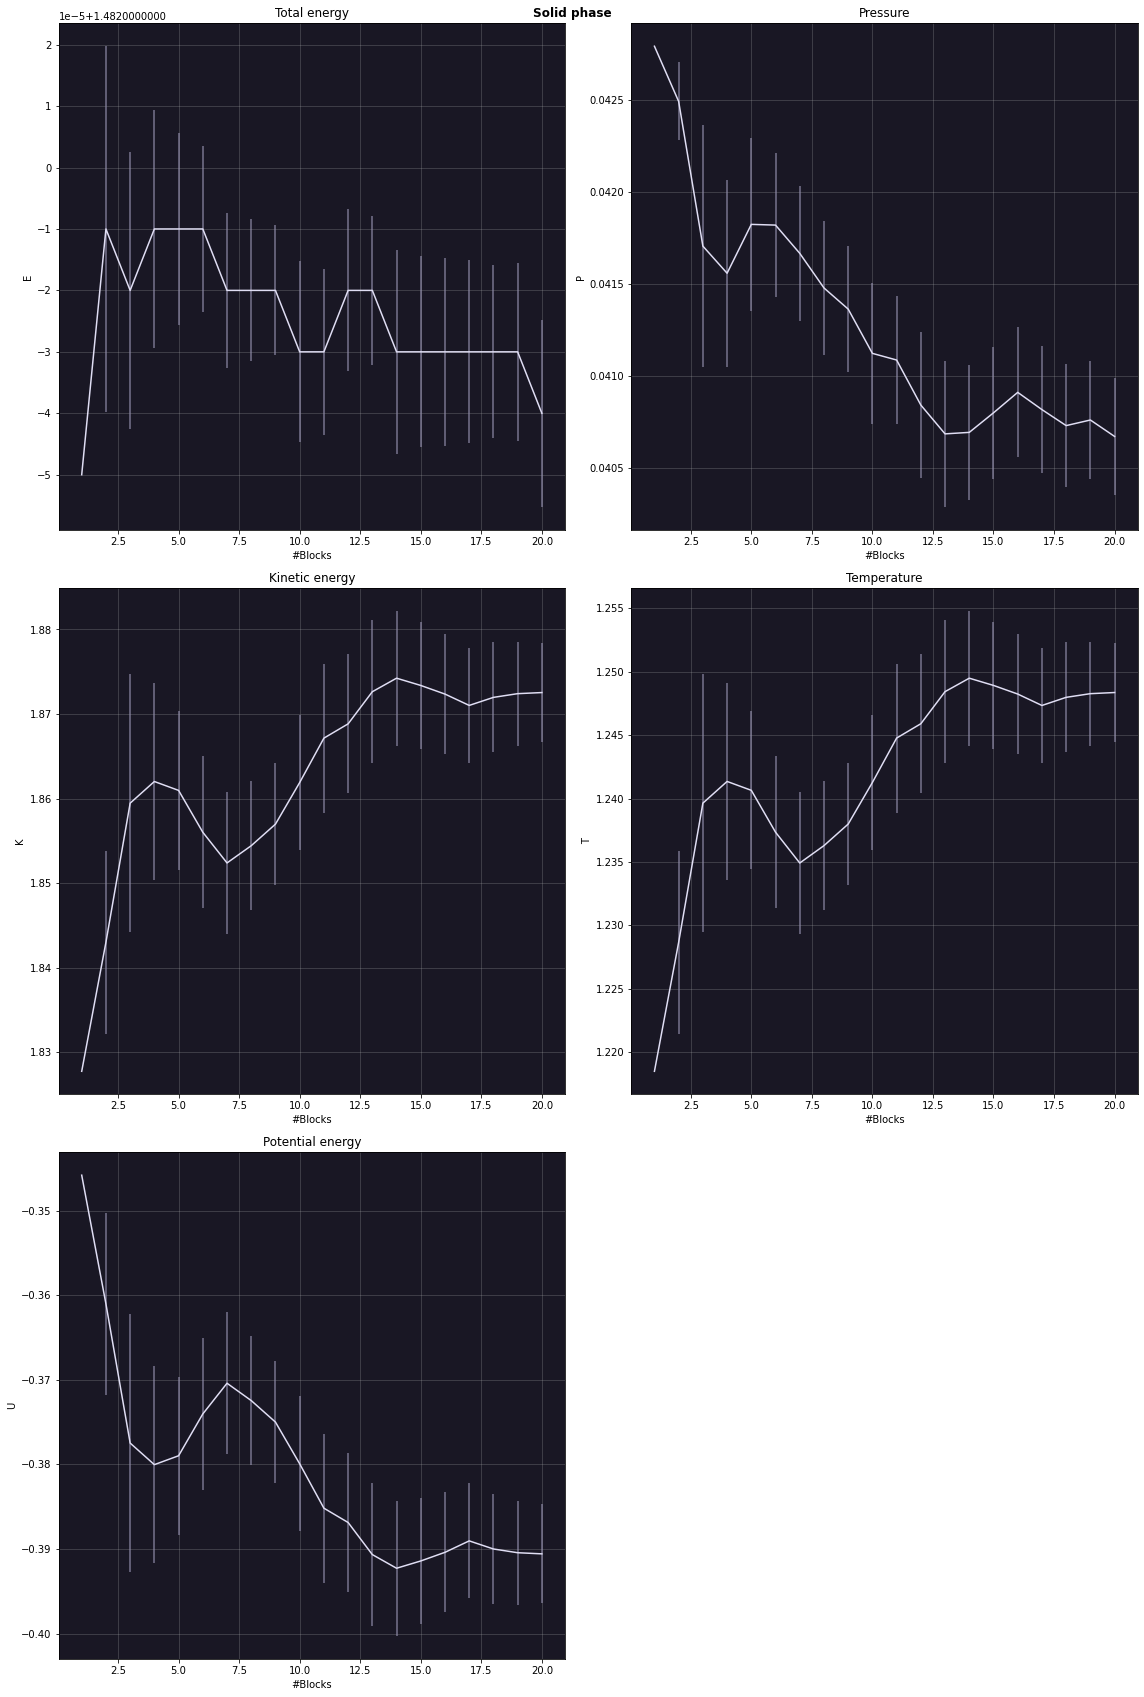

In [21]:
state="gas"

fig=plt.figure(figsize=(16, 24))
plt.suptitle('Solid phase', weight='bold')

#Total energy
x,y,e = np.loadtxt("out/"+state+"/output_etot.dat", usecols=(0,2,3),unpack=True)

plt.subplot(321)
fig.axes[0].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('E')
plt.title("Total energy")
plt.grid(alpha=0.3)

#Kinetic energy
x,y,e = np.loadtxt("out/"+state+"/output_ekin.dat", usecols=(0,2,3),unpack=True)

plt.subplot(323)
fig.axes[1].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('K')
plt.title("Kinetic energy")
plt.grid(alpha=0.3)

#Potential energy
x,y,e = np.loadtxt("out/"+state+"/output_epot.dat", usecols=(0,2,3),unpack=True)

plt.subplot(325)
fig.axes[2].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('U')
plt.title("Potential energy")
plt.grid(alpha=0.3)

#Pressure energy
x,y,e = np.loadtxt("out/"+state+"/output_pres.dat", usecols=(0,2,3),unpack=True)

plt.subplot(322)
fig.axes[3].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('P')
plt.title("Pressure")
plt.grid(alpha=0.3)

#Temperature energy
x,y,e = np.loadtxt("out/"+state+"/output_temp.dat", usecols=(0,2,3),unpack=True)

plt.subplot(324)
fig.axes[4].set_facecolor(stb)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('T')
plt.title("Temperature")
plt.grid(alpha=0.3)


plt.tight_layout()


plt.show()